# Beach classification

#### Imports

In [37]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split

#### Reading the data

In [38]:
df = pd.read_csv('beach-water-quality-automated-sensors-1.csv')

In [39]:
df.head(10)

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
0,Montrose Beach,08/30/2013 08:00:00 AM,20.3,1.18,0.891,0.080,3.0,9.4,8/30/2013 8:00 AM,MontroseBeach201308300800
1,Ohio Street Beach,05/26/2016 01:00:00 PM,14.4,1.23,NaN,0.111,4.0,12.4,05/26/2016 1:00 PM,OhioStreetBeach201605261300
2,Calumet Beach,09/03/2013 04:00:00 PM,23.2,3.63,1.201,0.174,6.0,9.4,9/3/2013 4:00 PM,CalumetBeach201309031600
3,Calumet Beach,05/28/2014 12:00:00 PM,16.2,1.26,1.514,0.147,4.0,11.7,5/28/2014 12:00 PM,CalumetBeach201405281200
4,Montrose Beach,05/28/2014 12:00:00 PM,14.4,3.36,1.388,0.298,4.0,11.9,5/28/2014 12:00 PM,MontroseBeach201405281200
5,Montrose Beach,05/28/2014 01:00:00 PM,14.5,2.72,1.395,0.306,3.0,11.9,5/28/2014 1:00 PM,MontroseBeach201405281300
6,Calumet Beach,05/28/2014 01:00:00 PM,16.3,1.28,1.524,0.162,4.0,11.7,5/28/2014 1:00 PM,CalumetBeach201405281300
7,Montrose Beach,05/28/2014 02:00:00 PM,14.8,2.97,1.386,0.328,3.0,11.9,5/28/2014 2:00 PM,MontroseBeach201405281400
8,Calumet Beach,05/28/2014 02:00:00 PM,16.5,1.32,1.537,0.185,4.0,11.7,5/28/2014 2:00 PM,CalumetBeach201405281400
9,Calumet Beach,05/28/2014 03:00:00 PM,16.8,1.31,1.568,0.196,4.0,11.7,5/28/2014 3:00 PM,CalumetBeach201405281500


#### Drop the collumns that we won't be needing for the classification

In [40]:
df=df.drop(['Measurement Timestamp', 'Measurement Timestamp Label','Measurement ID'], axis=1)

In [41]:
df

,Beach Name,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life
0,Montrose Beach,20.3,1.18,0.891,0.080,3.0,9.4
1,Ohio Street Beach,14.4,1.23,NaN,0.111,4.0,12.4
2,Calumet Beach,23.2,3.63,1.201,0.174,6.0,9.4
3,Calumet Beach,16.2,1.26,1.514,0.147,4.0,11.7
4,Montrose Beach,14.4,3.36,1.388,0.298,4.0,11.9
...,...,...,...,...,...,...,...
34918,Ohio Street Beach,19.9,2.61,NaN,0.187,3.0,10.5
34919,Ohio Street Beach,19.8,0.00,NaN,0.187,3.0,10.5
34920,Ohio Street Beach,22.3,0.00,NaN,0.187,3.0,10.5
34921,Ohio Street Beach,21.1,26.97,NaN,0.187,3.0,9.4


#### Data cleanup. Delete all entries that have NaN atributes

In [42]:
df = df.dropna(how='all')

In [43]:
cleaned_df = df.dropna(axis='rows')

In [44]:
beach_list=np.array(cleaned_df['Beach Name'])
unique_classes, counts = np.unique(beach_list, return_counts=True)
dict(zip(unique_classes, counts))

{'63rd Street Beach': 934,
 'Calumet Beach': 2128,
 'Montrose Beach': 2226,
 'Ohio Street Beach': 2003,
 'Osterman Beach': 1809,
 'Rainbow Beach': 934}

#### We see a slight imbalance between classes
#### Lets see the situation with the uncleaned data set

In [45]:
beach_list=np.array(df['Beach Name'])
unique_classes, counts = np.unique(beach_list, return_counts=True)
dict(zip(unique_classes, counts))

{'63rd Street Beach': 3420,
 'Calumet Beach': 7570,
 'Montrose Beach': 7269,
 'Ohio Street Beach': 9343,
 'Osterman Beach': 4023,
 'Rainbow Beach': 3298}

#### We could replace all NaN values with 0. The unbalance between classes in this case would be bigger though. We will proceed using the cleaned dataset.

#### Next we will normalize the data

In [48]:
def normalize(feature):
    return (feature - min(feature))/(max(feature)-min(feature))

cleaned_df['Water Temperature'] = normalize(cleaned_df['Water Temperature'])
cleaned_df['Turbidity'] = normalize(cleaned_df['Turbidity'])
cleaned_df['Transducer Depth'] = normalize(cleaned_df['Transducer Depth'])
cleaned_df['Wave Height'] = normalize(cleaned_df['Wave Height'])
cleaned_df['Wave Period'] = normalize(cleaned_df['Wave Period'])
cleaned_df['Battery Life'] = normalize(cleaned_df['Battery Life'])
cleaned_df

C:\Users\George\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\George\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\George\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,Beach Name,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life
0,Montrose Beach,0.749077,0.000992,0.423780,0.112985,0.222222,0.264151
2,Calumet Beach,0.856089,0.003050,0.558798,0.271501,0.555556,0.264151
3,Calumet Beach,0.597786,0.001059,0.695122,0.225970,0.333333,0.698113
4,Montrose Beach,0.531365,0.002823,0.640244,0.480607,0.333333,0.735849
5,Montrose Beach,0.535055,0.002286,0.643293,0.494098,0.222222,0.735849
...,...,...,...,...,...,...,...
11563,Montrose Beach,0.630996,0.000218,0.765244,0.138280,0.444444,0.264151
11564,Montrose Beach,0.630996,0.000521,0.794861,0.143339,1.000000,0.264151
11565,Montrose Beach,0.634686,0.000210,0.755226,0.145025,0.888889,0.264151
11566,Montrose Beach,0.634686,0.000176,0.770035,0.155143,0.666667,0.264151


In [11]:
cleaned_df.to_csv('normalised_data.csv')

In [12]:
X= np.array(cleaned_df[["Water Temperature", "Turbidity", "Transducer Depth", "Wave Height", "Wave Period", "Battery Life"]])
y= np.array(cleaned_df["Beach Name"])
classes = list(set(y))
class_to_int={}
for i in range(len(classes)):
    class_to_int[classes[i]]=i
y=np.array([class_to_int[element] for element in y])
int_to_class= {v: k for k, v in class_to_int.items()}

#### We can now see how each feature influence the class

Text(0, 0.5, 'Beach type')

<Figure size 1600x1600 with 0 Axes>

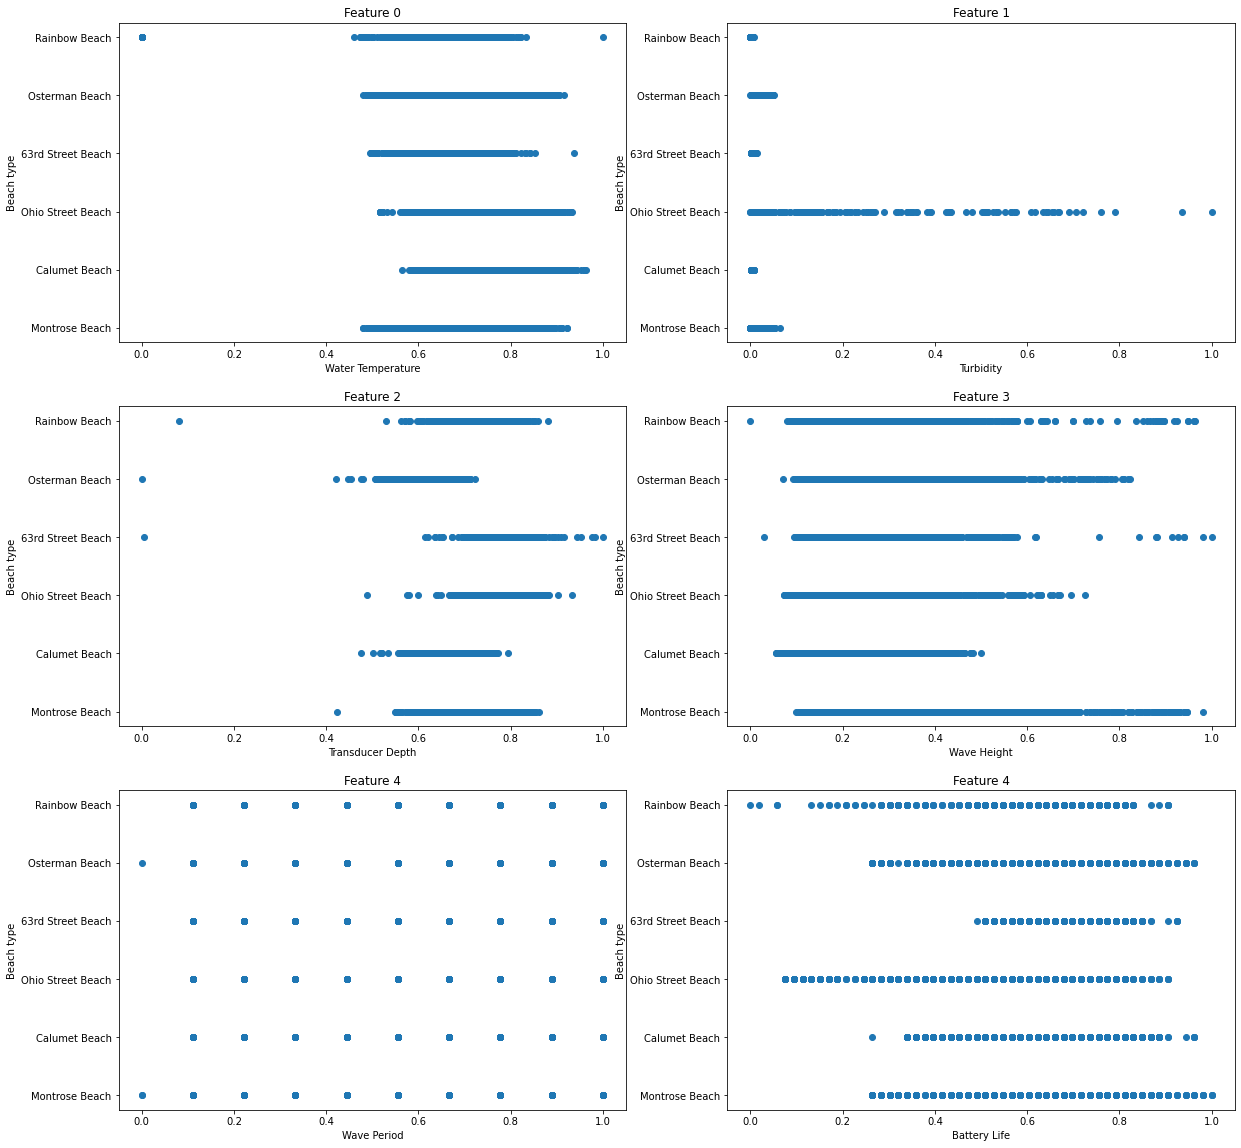

In [13]:
figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(3, 2,figsize=(20,20))

axs[0, 0].scatter(X[:,0], cleaned_df['Beach Name'])
axs[0, 0].set_title('Feature 0')
axs[0, 0].set_xlabel('Water Temperature')
axs[0, 0].set_ylabel('Beach type')
axs[0, 1].scatter(X[:,1], cleaned_df['Beach Name'])
axs[0, 1].set_title('Feature 1')
axs[0, 1].set_xlabel('Turbidity')
axs[0, 1].set_ylabel('Beach type')
axs[1, 0].scatter(X[:,2], cleaned_df['Beach Name'])
axs[1, 0].set_title('Feature 2')
axs[1, 0].set_xlabel('Transducer Depth')
axs[1, 0].set_ylabel('Beach type')
axs[1, 1].scatter(X[:,3], cleaned_df['Beach Name'])
axs[1, 1].set_title('Feature 3')
axs[1, 1].set_xlabel('Wave Height')
axs[1, 1].set_ylabel('Beach type')
axs[2, 0].scatter(X[:,4], cleaned_df['Beach Name'])
axs[2, 0].set_title('Feature 4')
axs[2, 0].set_xlabel('Wave Period')
axs[2, 0].set_ylabel('Beach type')
axs[2, 1].scatter(X[:,5], cleaned_df['Beach Name'])
axs[2, 1].set_title('Feature 4')
axs[2, 1].set_xlabel('Battery Life')
axs[2, 1].set_ylabel('Beach type')



#### As we can see there is no real corelation between one feature and a class

#### Lets also check for corelations between features

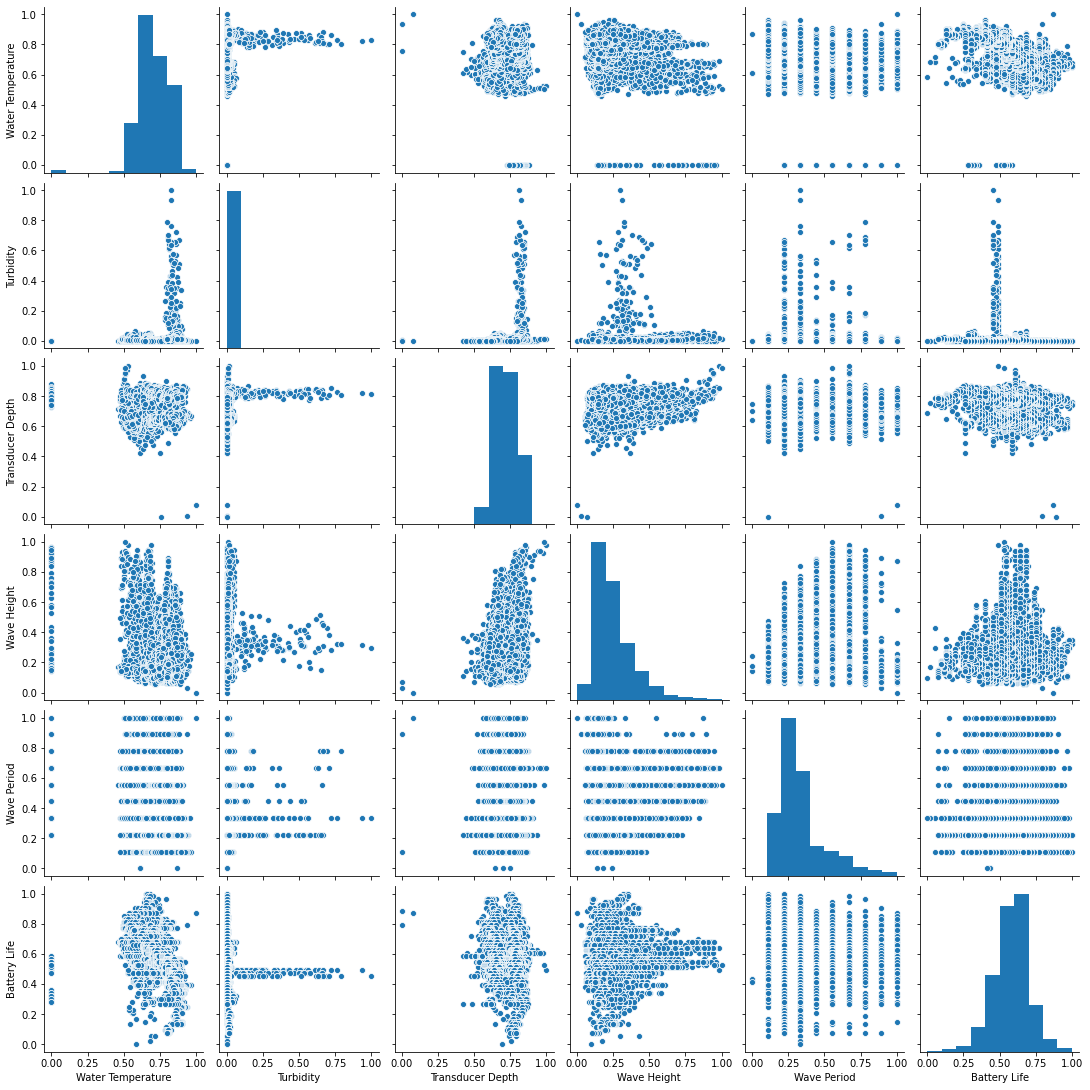

In [14]:
features = cleaned_df.drop('Beach Name', axis=1)
sns.pairplot(features)
plt.show()

#### The Turbidity feature will affect our learning process due to its poor distribution

### Time to split our data in train and test 

#### We will use our previously defined dictionary to change the class value from string to int

In [15]:
cleaned_df['Beach Name'] = [class_to_int[x] for x in cleaned_df['Beach Name']]

C:\Users\George\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
cleaned_df['Beach Name'] 

0        1
2        2
3        2
4        1
5        1
        ..
11563    1
11564    1
11565    1
11566    1
11567    1
Name: Beach Name, Length: 10034, dtype: int64

#### We will use scikit-learn train_test_split to split our data

In [17]:

cleaned_df=cleaned_df.reset_index()
cleaned_df = cleaned_df.drop('index', axis=1)
X = cleaned_df.drop('Beach Name', axis=1).values
y = cleaned_df['Beach Name'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [18]:
X_train.shape, y_train.shape

(torch.Size([8027, 6]), torch.Size([8027]))

## Time to define our model

### 1ST model

In [19]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=6, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=12)
        self.output = nn.Linear(in_features=12, out_features=6)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [20]:
model = Model()
model

Model(
  (fc1): Linear(in_features=6, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=12, bias=True)
  (output): Linear(in_features=12, out_features=6, bias=True)
)

#### Let's define our criteria
We have 6 classes and 6 output neurons. Cross Entropy will be our criteria of choice

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [22]:
%%time
epochs = 600
loss_arr = []
for i in range(epochs):
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    loss_arr.append(loss)

    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 1.835860252380371
Epoch: 10 Loss: 1.759854793548584
Epoch: 20 Loss: 1.7205796241760254
Epoch: 30 Loss: 1.6910457611083984
Epoch: 40 Loss: 1.6463335752487183
Epoch: 50 Loss: 1.575911283493042
Epoch: 60 Loss: 1.4590424299240112
Epoch: 70 Loss: 1.295500636100769
Epoch: 80 Loss: 1.1585049629211426
Epoch: 90 Loss: 1.08383047580719
Epoch: 100 Loss: 1.0342046022415161
Epoch: 110 Loss: 0.9964163899421692
Epoch: 120 Loss: 0.9692831039428711
Epoch: 130 Loss: 0.9519947171211243
Epoch: 140 Loss: 0.9376160502433777
Epoch: 150 Loss: 0.9232749342918396
Epoch: 160 Loss: 0.9103713631629944
Epoch: 170 Loss: 0.8987830281257629
Epoch: 180 Loss: 0.8888751864433289
Epoch: 190 Loss: 0.8807182312011719
Epoch: 200 Loss: 0.8751357793807983
Epoch: 210 Loss: 0.8687557578086853
Epoch: 220 Loss: 0.864440381526947
Epoch: 230 Loss: 0.8617587685585022
Epoch: 240 Loss: 0.8578621745109558
Epoch: 250 Loss: 0.8553212285041809
Epoch: 260 Loss: 0.8529208898544312
Epoch: 270 Loss: 0.8502734303474426
Epoch: 280

Text(0, 0.5, 'Loss')

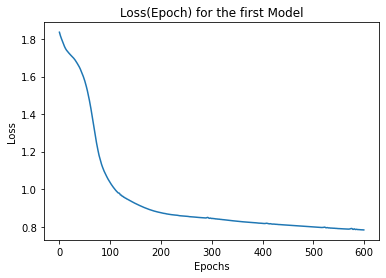

In [23]:
plt.plot(loss_arr)
plt.title("Loss(Epoch) for the first Model")
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Let's also test our accuracy on the test data

In [24]:
preds = []
with torch.no_grad():
    for val in X_test:
        y_hat = model.forward(val)
        preds.append(y_hat.argmax().item())

In [25]:
df = pd.DataFrame({'Y': y_test, 'YHat': preds})
df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['YHat'])]

In [26]:
df

,Y,YHat,Correct
0,4,4,1
1,0,5,0
2,3,3,1
3,4,4,1
4,3,1,0
...,...,...,...
2002,4,4,1
2003,0,1,0
2004,1,1,1
2005,0,0,1


In [27]:
print('First model accuracy is {}'.format(df['Correct'].sum() / len(df)))

First model accuracy is 0.6796213253612357


#### 68 % Accuracy is a good start. We shall continue with a more complex model to see if we can increase this accuracy

### 2ND model

In [28]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=6, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=12)        
        self.output = nn.Linear(in_features=12, out_features=6)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x
model = Model()
model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [29]:
%%time
epochs = 4000
loss_arr = []
for i in range(epochs):
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    loss_arr.append(loss)

    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 1.7926322221755981
Epoch: 10 Loss: 1.7362967729568481
Epoch: 20 Loss: 1.7014485597610474
Epoch: 30 Loss: 1.6468441486358643
Epoch: 40 Loss: 1.6138982772827148
Epoch: 50 Loss: 1.562105417251587
Epoch: 60 Loss: 1.4548892974853516
Epoch: 70 Loss: 1.3131871223449707
Epoch: 80 Loss: 1.1341533660888672
Epoch: 90 Loss: 1.048404335975647
Epoch: 100 Loss: 0.9962996244430542
Epoch: 110 Loss: 0.9758051633834839
Epoch: 120 Loss: 0.9493282437324524
Epoch: 130 Loss: 0.932929277420044
Epoch: 140 Loss: 0.9186920523643494
Epoch: 150 Loss: 0.9066101312637329
Epoch: 160 Loss: 0.8955174088478088
Epoch: 170 Loss: 0.885816752910614
Epoch: 180 Loss: 0.879241943359375
Epoch: 190 Loss: 0.8699759840965271
Epoch: 200 Loss: 0.8624556660652161
Epoch: 210 Loss: 0.8550497889518738
Epoch: 220 Loss: 0.8675927519798279
Epoch: 230 Loss: 0.8493269681930542
Epoch: 240 Loss: 0.8414093255996704
Epoch: 250 Loss: 0.8345534801483154
Epoch: 260 Loss: 0.8296642303466797
Epoch: 270 Loss: 0.8283822536468506
Epoch: 2

Epoch: 2260 Loss: 0.6290656328201294
Epoch: 2270 Loss: 0.6286947131156921
Epoch: 2280 Loss: 0.6287782192230225
Epoch: 2290 Loss: 0.6288734674453735
Epoch: 2300 Loss: 0.6459710001945496
Epoch: 2310 Loss: 0.6393313407897949
Epoch: 2320 Loss: 0.6294455528259277
Epoch: 2330 Loss: 0.6292689442634583
Epoch: 2340 Loss: 0.6303404569625854
Epoch: 2350 Loss: 0.6303225755691528
Epoch: 2360 Loss: 0.6279162764549255
Epoch: 2370 Loss: 0.6279898285865784
Epoch: 2380 Loss: 0.6371746063232422
Epoch: 2390 Loss: 0.627819299697876
Epoch: 2400 Loss: 0.6255835294723511
Epoch: 2410 Loss: 0.6297411322593689
Epoch: 2420 Loss: 0.6295661926269531
Epoch: 2430 Loss: 0.626002848148346
Epoch: 2440 Loss: 0.6254749298095703
Epoch: 2450 Loss: 0.6287364959716797
Epoch: 2460 Loss: 0.6337200999259949
Epoch: 2470 Loss: 0.6265702247619629
Epoch: 2480 Loss: 0.6237323880195618
Epoch: 2490 Loss: 0.6240769624710083
Epoch: 2500 Loss: 0.6253820657730103
Epoch: 2510 Loss: 0.630499005317688
Epoch: 2520 Loss: 0.622974157333374
Epoch

In [30]:
preds = []
with torch.no_grad():
    for val in X_test:
        y_hat = model.forward(val)
        preds.append(y_hat.argmax().item())
df = pd.DataFrame({'Y': y_test, 'YHat': preds})
df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['YHat'])]
print('Second model accuracy is {}'.format(df['Correct'].sum() / len(df)))

Second model accuracy is 0.7658196312904834


#### 76 % accuracy. My goal is to reach over 90% accuracy for this dataset 

### 3RD model

#### Here I will adjust the learning rate, epoch wise.

In [31]:
#Parameters
learning_rate= 1e-2
def TestAccuracy():
    preds = []
    with torch.no_grad():
        for val in X_test:
            y_hat = model.forward(val)
            preds.append(y_hat.argmax().item())
    df = pd.DataFrame({'Y': y_test, 'YHat': preds})
    df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['YHat'])]
    print('Third model accuracy is {}'.format(df['Correct'].sum() / len(df)))
    
def adjust_learning_rate(optimizer, epoch):
    if( epoch %800==0 and epoch != 0):
        lr = learning_rate / (2 ** (epoch // 5000))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Learning rate got halved')

In [32]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=6, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=6)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x
model = Model()
model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [33]:
%%time
epochs = 2400
loss_arr = []
for i in range(epochs):
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    loss_arr.append(loss)

    if i % 100 == 0:
        print(f'Epoch: {i} Loss: {loss}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%200 == 0:
        TestAccuracy()
    adjust_learning_rate(optimizer,i)

Epoch: 0 Loss: 1.7776379585266113
Third model accuracy is 0.22770303936223218
Epoch: 100 Loss: 0.8430750966072083
Epoch: 200 Loss: 0.9074060320854187
Third model accuracy is 0.7125062282012955
Epoch: 300 Loss: 0.6678357124328613
Epoch: 400 Loss: 0.5832952260971069
Third model accuracy is 0.7513702042850025
Epoch: 500 Loss: 0.532032310962677
Epoch: 600 Loss: 0.5001859068870544
Third model accuracy is 0.7862481315396114
Epoch: 700 Loss: 0.486805260181427
Epoch: 800 Loss: 0.45523959398269653
Third model accuracy is 0.802192326856004
Learning rate got halved
Epoch: 900 Loss: 0.41930755972862244
Epoch: 1000 Loss: 0.38859349489212036
Third model accuracy is 0.8216243148978575
Epoch: 1100 Loss: 0.36582472920417786
Epoch: 1200 Loss: 0.3533872663974762
Third model accuracy is 0.8355754857997011
Epoch: 1300 Loss: 0.33399882912635803
Epoch: 1400 Loss: 0.32286807894706726
Third model accuracy is 0.8450423517688092
Epoch: 1500 Loss: 0.30271390080451965
Epoch: 1600 Loss: 0.2911788821220398
Third mod

Text(0, 0.5, 'Loss')

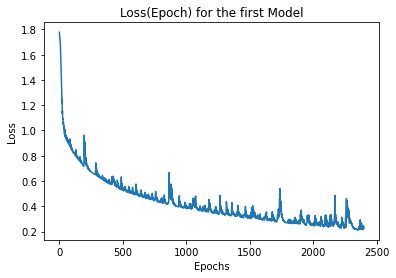

In [35]:
plt.plot(loss_arr)
plt.title("Loss(Epoch) for the Third Model")
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [34]:
TestAccuracy()

Third model accuracy is 0.8684603886397608


## I tried making the model more complex but it did not yield better results. With a 4 layer model I was able to achieve an accuracy of 86.84 % 